In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

from tqdm import tqdm

import matplotlib.pyplot as plt

from models import GPT
from tokenizers import Tokenizer

from utils import BatchLoader, estimate_loss, train_loop, load, save

# hyperparameters
batch_size = 16  # number of independent sequences that'll be processed in parallel
block_size = 128  # maximum context length for the preds
max_iters = 1000
eval_interval = 200
learning_rate = 3e-4
device = "mps" if torch.backends.mps.is_available() else "cpu"
eval_iters = 200
n_embd = 256
n_head = 4
n_blocks = 4
dropout = 0.2
# --------------

torch.manual_seed(1337)

# data preparation
text = open("dataset/tinyshakespeare.txt", "r").read()
# set up the vocabulary
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
tokenizer = Tokenizer(chars)

data = torch.tensor(tokenizer.encode(text), dtype=torch.long)

n = int(0.9 * len(data))  # first 90% will be the training set
n1 = int(0.95 * len(data))  # 90-95% will be the validation set and the last 5% will be the calibration set for the paper

train_data = data[:n]
val_data = data[n:n1]
calibrate_data = data[n1:]

train_loader = BatchLoader(train_data, block_size, batch_size, device, name="train")
val_loader = BatchLoader(val_data, block_size, batch_size, device, name="val")
calibration_loader = BatchLoader(calibrate_data, block_size, batch_size, device, name="calibrate")


UNIFORM BASELINE:  4.174387454986572


step 800: train loss 2.0375, val loss 2.0717,  	 | baseline (uniform random): 4.1744: 100%|██████████| 1000/1000 [01:22<00:00, 12.10it/s]


training is done!


Appy ecreace flesh, quince bouboal ford?
Habr And sirear his spown Poghe so inge kit shaAnd wall
By gorable ard, eye shavered:
A'lloel westhe briffordes I'll chacen fallownd.
This worsh anch, Maind bearshord've is;
ICIN my bowrin cow to wat Lrd:
Whe shat the not how, dod bre to blik,
NaK:
Presas me thons migul sis
This I thom counean, her soffess, For 's thombabe;
Thid she dinss meace pastrem tjrakenin hack as, hip?
Baven this it taceice wi disen hty pared so.

INGHUS:
To ard will asteros, will


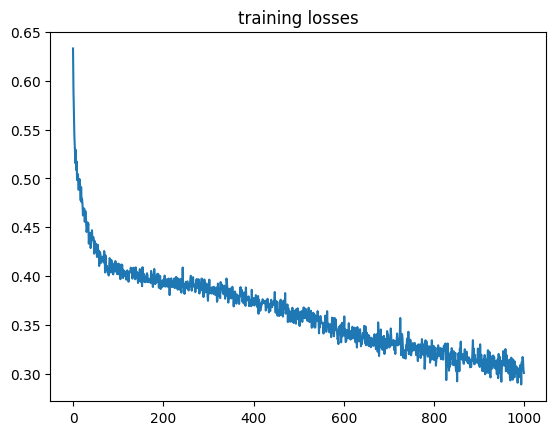

In [2]:
model = GPT(vocab_size, block_size, n_embd, n_head, n_blocks, device, dropout)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

training_losses = train_loop(model, optimizer, vocab_size, train_loader, [train_loader, val_loader], max_iters, eval_interval, eval_iters)

print("training is done!")

plt.title("training losses")
plt.plot(training_losses)
plt.savefig("training_losses.png")

idx = torch.zeros((1, 1), dtype=torch.long, device=device)
print(tokenizer.decode(model.generate(idx, max_new_tokens=500)[0].tolist()))

In [3]:
model_params = {
    "vocab_size": vocab_size,
    "block_size": block_size,
    "n_embd": n_embd,
    "n_head": n_head,
    "n_blocks": n_blocks,
    "dropout": dropout,
    "device": device
}

save(model, tokenizer, model_params, "model")

In [4]:
def attn_head_importance_hook(module, ins, outs) -> None: # TODO: does the importance calculation returns the correct values for each head? 
    """ calculates the multi-head-attention layer's importance per head """
    # outs.shape = (B, T, E) where B: batch_size, T: num tokens, E: embedding size
    # the importance is calculated as summing the L2 norm of the attn outputs on B and T dimensions
    outs_flat = outs.view(-1, outs.shape[-1]) # (b,t,e) -> (b*t, e)
    importance = torch.linalg.vector_norm(outs_flat.detach().cpu(), ord=2, dim=-1).sum()

    module.calculated_importance = importance
    
    # print(outs_flat.shape)
    # print("module:", module.__class__.__name__, end=" ")
    # print("importance:", importance)
    # print(f"{module.__class__.__name__} importance: {importance.shape}")

def neuron_importance_hook(module, ins, outs) -> None:
    """ calculates the neuron importance for the given layer """ 
    
    # the ffwd linear weights should be in the shape of (out, in)
    # the paper sums up the values of (X * W_i^T) meaning (B, T, in) x (in, 1)= (B,T,1) -> (1, ) (summed up)
    
    # thus, in order to vectorize this operation, we'll need to hook this function to the first linear layer itself rather than the whole ffwd block. 

    # for each neuron in the ffwd layer, we can simply sum up the output columns

    # as they're the activations of individual neurons
    # calculate the importances
    # importance = outs.detach().sum()
    importance = outs.detach().cpu().sum(dim=(0,1))
    # print(f"{module.__class__.__name__} importance.shape: {importance.shape}")

    module.calculated_importance = importance

def embedding_importance_hook(module, ins, outs) -> None:
    # the first block's first processing layer will be the 
    # layer norm
    # so we'll just sum up the layer norm outputs after getting them
    # calculate the importances

    importance = outs.detach().sum(dim=(0,1))
    # print("importance.shape:", importance.shape)
    # print("n_embd: ", outs.size(-1))
    # print("module:", module.__class__.__name__)
    # print("outs.shape:", outs.shape) # probably (B, T, E)
 
    module.calculated_importance = importance

    # print(f"{module.__class__.__name__} importance.shape: {importance.shape}")

def block_importance_hook(module, ins, outs) -> None:
   
    in_vectors = ins[0].detach()  # (B, T, E)
    out_vectors = outs.detach()   # (B, T, E)
    
    # Calculate cosine similarity for each sample and time step
    dot_product = torch.sum(in_vectors * out_vectors, dim=-1)  # (B, T)
    in_norm = torch.norm(in_vectors, p=2, dim=-1)  # (B, T)
    out_norm = torch.norm(out_vectors, p=2, dim=-1)  # (B, T)
    
    cosine_sim = dot_product / (in_norm * out_norm + 1e-8)  # (B, T)
    
    # Calculate BI by taking the expectation (mean) and subtracting from 1
    block_importance = 1 - torch.mean(cosine_sim)
    
    # print("Block Importance:", block_importance.item())
    # print("module:", module.__class__.__name__)
    # print("outs.shape:", outs.shape)  # (B, T, E)
 
    module.calculated_importance = block_importance

    # print(f"{module.__class__.__name__} importance.shape: {block_importance.shape}")

In [5]:
# set up the initial hooks for all the corresponding layers
from models import Block, GPT

def delete_importance_attr(layer: nn.Module):
    if hasattr(layer, "calculated_importance"):
        del layer.calculated_importance

def remove_all_forward_hooks(model: GPT):
    if not isinstance(model, GPT):
        raise NotImplementedError("Only GPT models are supported for now")
    
    for module in model.modules():
        if isinstance(module, Block):
            for head in module.sa.heads:
                head._forward_hooks.clear()
                delete_importance_attr(head)

            module.ffwd.net[0]._forward_hooks.clear()
            module.ln1._forward_hooks.clear()
            module.sa._forward_hooks.clear()

            delete_importance_attr(module.ffwd.net[0])
            delete_importance_attr(module.ln1)
            delete_importance_attr(module.sa)

def register_all_forward_hooks(model: GPT):
    if not isinstance(model, GPT):
        raise NotImplementedError("Only GPT models are supported for now")

    num_blocks = 0
    for module in model.modules():
        if isinstance(module, Block):
            num_blocks += 1
            for head in module.sa.heads:
                head.register_forward_hook(attn_head_importance_hook)
            module.ffwd.net[0].register_forward_hook(neuron_importance_hook) # register the forward hook to the linear layer inside of the ffwd block
            module.ln1.register_forward_hook(embedding_importance_hook)
            module.register_forward_hook(block_importance_hook)

In [6]:
def reinit_models():
    loaded_model, tokenizer = load(GPT, "model")
    loaded_model.to(device);

    remove_all_forward_hooks(loaded_model)
    register_all_forward_hooks(loaded_model)

    return loaded_model, tokenizer

model, tokenizer = reinit_models()

# estimate_loss(model, val_loader) # 2.0079

/Users/alperiox/Desktop/coding/paper-implts/Compact_Language_Models_240714679/utils.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(sav

In [26]:
def get_model():
    model, tokenizer = reinit_models()
    s = 0
    for k in model.parameters():
        if k.requires_grad:
            s += k.numel()
    print("# trainable parameters:", s)

    sample_batch = calibrate_data[:batch_size*block_size]
    sample_batch = sample_batch.view(batch_size, block_size)
    sample_batch = sample_batch.to(device)

    model(sample_batch);

    return model, s

In [27]:
# neuron and head pruning? 

# start with neuron pruning

def prune_neurons(model, ratio=0.2) -> None:
    # goal: trim the MLP layer weights
    # 1 - argsort the importances of the `ffwd` layers defined in the model
    # 2 - remove the weights with respect to the given ratio

    for module in model.modules():
        if isinstance(module, Block):
            importances = module.ffwd.net[0].calculated_importance 
            num_neurons = int((1-ratio) * importances.size(0))
            idx = importances.argsort(descending=True)[:num_neurons]
            # reinitialize the weights along with the layer
            dense1 = module.ffwd.net[0]
            dense2 = module.ffwd.net[2]

            module.ffwd.net[0] = nn.Linear(dense1.in_features, num_neurons).to(model.device) # weights.shape = (num_neurons, dense1.in_features)
            module.ffwd.net[2] = nn.Linear(num_neurons, dense2.out_features).to(model.device) # weights.shape = (dense2.out_features = emb)

            # now we need to set the weights to the new layers.

            dense1.weight.data = dense1.weight.data[idx, :]
            dense1.bias.data = dense1.bias.data[idx]

            dense2.weight.data = dense2.weight.data[idx, :]
            dense2.bias.data = dense2.bias.data[idx]
    
    return model


def prune_heads(model, ratio=0.2) -> None:
    # goal: trim the attention heads' layer weights using the same approach as the `prune_neurons`
    pass


def prune_embeddings(model, ratio=0.2) -> None:
    # goal: trim the embedding dimension of the weight matrices in MLP, MHA, and LayerNorm layers.
    # TODO: check how embedding importance is calculated!
    
    for module in model.modules():
        if isinstance(module, Block):
            # start with pruning the MLP layers
            importances = module.ln1.calculated_importance

            dense1 = module.ffwd.net[0] # weights.shape = (emb, 4 * emb)
            dense2 = module.ffwd.net[2] # weights.shape = (4 * emb, emb)

            num_dense_embd = int((1-ratio) * dense1.in_features)
            idx = importances.argsort(descending=True)[:num_dense_embd]

            module.ffwd.net[0] = nn.Linear(num_dense_embd, dense1.out_features).to(model.device) # weights.shape = (num_dense_embd, dense1.in_features)
            module.ffwd.net[2] = nn.Linear(dense2.in_features, num_dense_embd).to(model.device) # weights.shape = (dense2.out_features = emb)

            module.ffwd.net[0].weight.data = dense1.weight.data[:, idx]
            module.ffwd.net[0].bias.data = dense1.bias.data
            module.ffwd.net[2].weight.data = dense2.weight.data[idx, :]
            module.ffwd.net[2].bias.data = dense2.bias.data[idx]
        
            # now the multi-head attention
            for head in module.sa.heads:
                # key,value,query weight shape: (head_size, n_embd) # n_embd
                k,v,q = head.key, head.value, head.query
                  
                head.key = nn.Linear(num_dense_embd, head.head_size, bias=False).to(model.device) 
                head.value = nn.Linear(num_dense_embd, head.head_size, bias=False).to(model.device) 
                head.query = nn.Linear(num_dense_embd, head.head_size, bias=False).to(model.device) 

                head.key.weight.data = k.weight.data[:, idx] # (head_size, num_dense_embd)
                head.value.weight.data = v.weight.data[:, idx] # (head_size, num_dense_embd)
                head.query.weight.data = q.weight.data[:, idx] # (head_size, num_dense_embd)

                # TODO: only the weights in the embedding layers are prunned (1st strategy)
                # TODO: need to follow the correct implementation from the paper (pruning every linear layer?)

            ln1 = module.ln1
            ln2 = module.ln2

            module.ln1 = nn.LayerNorm(num_dense_embd).to(model.device) 
            module.ln1.weight.data = ln1.weight.data[idx]
            module.ln1.bias.data = ln1.bias.data[idx]

            module.ln2 = nn.LayerNorm(num_dense_embd).to(model.device) 
            module.ln2.weight.data = ln2.weight.data[idx]
            module.ln2.bias.data = ln2.bias.data[idx]

            proj = module.sa.proj
            module.sa.proj = nn.Linear(n_embd, num_dense_embd).to(model.device) 
            module.sa.proj.weight.data = proj.weight.data[idx, :] # (num_dense_embd, n_embd)
            module.sa.proj.bias.data = proj.bias.data[idx]
    
    temb_table = model.token_embedding_table
    pemb_table = model.position_embedding_table

    model.token_embedding_table = nn.Embedding(vocab_size, num_dense_embd).to(device)
    model.position_embedding_table = nn.Embedding(model.block_size, num_dense_embd).to(device)

    model.token_embedding_table.weight.data = temb_table.weight.data[:, idx]
    model.position_embedding_table.weight.data = pemb_table.weight.data[:, idx]

    lnf = model.ln_f
    ln_head = model.ln_head

    model.ln_f = nn.LayerNorm(num_dense_embd).to(device)
    model.ln_head = nn.Linear(num_dense_embd, model.vocab_size).to(device) 

    model.ln_f.weight.data = lnf.weight.data[idx]
    model.ln_f.bias.data = lnf.bias.data[idx]
    model.ln_head.weight.data = ln_head.weight.data[:, idx] # weight.shape = (vocab_size, embd)
    model.ln_head.bias.data = ln_head.bias.data

In [28]:
model, s = get_model()

/Users/alperiox/Desktop/coding/paper-implts/Compact_Language_Models_240714679/utils.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(sav

# trainable parameters: 3222593


In [29]:
prune_neurons(model, 0.2)
prune_embeddings(model, 0.2)

In [30]:
t = 0
for k in model.parameters():
    if k.requires_grad:
        t += k.numel()
print(t)

print("total difference: ", s-t)
print("diff ratio: ", (s-t)/s)

2233469
total difference:  989124
diff ratio:  0.30693419864065985


In [31]:
estimate_loss(model, val_loader)

{'val': tensor(3.9592)}

In [32]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=3e-3)

In [33]:
calibrate_data.shape[0] / train_data.shape[0]

0.05555588760915432

In [34]:
losses = train_loop(model, optimizer, vocab_size, calibration_loader, [calibration_loader, val_loader], max_iters = 200, eval_interval=50, eval_iters=50)

UNIFORM BASELINE:  4.174387454986572


step 150: calibrate loss 2.2718, val loss 2.3416,  	 | baseline (uniform random): 4.1744: 100%|██████████| 200/200 [00:27<00:00,  7.29it/s]


In [35]:
estimate_loss(model, val_loader)

{'val': tensor(2.2010)}

In [38]:
idx = torch.zeros((1, 1), dtype=torch.long, device=device)
y = model(idx)


In [41]:
idx = torch.zeros((1, 1), dtype=torch.long, device=device)
print(tokenizer.decode(model.generate(idx, max_new_tokens=500)[0].tolist()))


cean cablikntees
A-:
Hakn Iblast tound om ninceined sling?
My wend he prorr:
Mod mig,
s ie, w who sithe suby, st, thid hand shin ght. bud pond t, htes, ourthan.
A st my when's ud PETIAnd y, d, polad l ad, hivand mses. y?
ano,


PPRO:
PEThyo'd to my, w, se syou lyand sshay t ye ned hak's peakearnst je. s,
And wn. SI nd s le My atith wofa de an,-fr she tharof thak By sswa mo mo De bu, GRe, d. ANDhise waou nt histbe, os y tow mirho se; ba nenerer nir I in byhealin s re fo y cat whethe s inge y nd.

